In [1]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")
from adjustText import adjust_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LinearRegression
import statsmodels.api as sm
import matplotlib
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sns
import RELACS as rel
import pymc3 as pm
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: Run

# Create reference consensus bin set for epigenomic analysis

- Create a consensus peak set between cell-types (merge regions that are closer than 5000bp);
- Bin the consensus set (bin size = 2000; discard regions that are shorter that 500bp);
- Retrieve counts for each bin and for each histone modification using multiBamSummary;


In [1]:
%%bash

### CREATE CONSENSUS OF ALL PEAKS OF mESC AND NPC48h ###

cat ../INPUT_DATA/NPC48h_H3K27ac_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K27ac_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K4me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K4me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K4me1_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K4me1_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K79me2_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K79me2_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K27me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K27me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K36me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K36me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K9me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K9me3_BAMPE-BAM_consensusPeaks.bed | bedtools sort | \
bedtools merge -d 5000 | awk -v OFS="\t" '{a+=1; print $0,"peakRegion_"a, $3-$2}' > ../INTERMEDIATE_FILES/EnrichedRegions_allMarks.bed

In [76]:
### NORMALIZE THE CONSENSUS SET SO THAT EACH REGION IS A MULTIPLE OF 2000bp AND REMOVE REGIONS SHORTER THAT 500bp ###

bins_min = 500
bins=2000
regions = pd.read_csv("../INTERMEDIATE_FILES/EnrichedRegions_allMarks.bed", sep="\t", header=None, names=["chr","start","end","peak_ID","len"])
regions_500 = regions.loc[(regions.end.values - regions.start.values)>bins_min]
regions_500["length"] = regions_500.end.values - regions_500.start.values
regions_500["to_add"] = np.ceil((bins - (regions_500.length.values % bins)) / 2)
regions_500["start"] = (regions_500.start - regions_500.to_add).astype(int)
regions_500["end"] = (regions_500.end + regions_500.to_add).astype(int)
regions_500["length"] = regions_500.end.values - regions_500.start.values
regions_500["end"] = [regions_500["end"].values[i] if regions_500["length"].values[i]%bins == 0 else regions_500["end"].values[i]-1 for i in range(len(regions_500["end"].values))]
regions_500["length"] = regions_500.end.values - regions_500.start.values

regions_500[["chr","start","end","peak_ID"]].to_csv("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed.bed", sep="\t", header=False, index=False)
regions_500.head()

/package/anaconda3/bin/ipython:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/package/anaconda3/bin/ipython:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/package/anaconda3/bin/ipython:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from IPython import

,chr,start,end,peak_ID,len,length,to_add
0,1,3030703,3034703,peakRegion_1,2081,4000,960.0
1,1,3041906,3043906,peakRegion_2,729,2000,636.0
2,1,3051186,3057186,peakRegion_3,5172,6000,414.0
3,1,3061150,3071150,peakRegion_4,8707,10000,647.0
4,1,3141888,3157888,peakRegion_5,14833,16000,584.0


In [77]:
### BIN THE NORMALIZED CONSENSUS SET ###

keep = [str(i) for i in list(range(1,20))] + ["X","Y"]
with open("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed.bed") as inp, open("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed", "w") as out:
    p=0
    for line in inp:
        lista=line.strip().split()
        if lista[0] in keep:
            times = int((int(lista[2]) - int(lista[1])) / bins )
            start = int(lista[1])
            for k in range(times):
                p+=1
                out.write("\t".join([lista[0], str(int(start)), str(int(start+bins)), "bin_{}\n".format(p)]))
                start = start+bins

In [21]:
%%bash

### RETRIEVE COUNTS PER BIN PER HISTONE MARK PER SAMPLE ###

multiBamSummary BED-file -b ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.mat.gz --outRawCounts ../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.counts \
--BED ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed -bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
-p 20 -e --minMappingQuality 3

Number of bins found: 250988


# Perform Multi Factor Analysis on the VST count matrix

- Import counts and preprocess;
- Perform VST transformation on counts;
- Select the 500 most variable bins in the VST matrix for each histone mark;
- Perform Multi Factor Analysis;
- Plot results

In [2]:
### IMPORT COUNTS AND PREPROCESS ###

keep = [str(i) for i in list(range(1,20))] + ["X","Y"]
counts = pd.read_csv("../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.counts", sep="\t")

counts_ref = rel.preprocess_deeptools(counts, merge_rep=True, list_of_columns=[[0],[8],[1],[9],[2],[10],[3],[11],[4],[12],[5],[13],[6],[14],
                                                                               [16],[24],[17],[25],[18],[26],[19],[27],[20],[28],[21],[29],[22],[30]])
counts_log = rel.preprocess_deeptools(counts, log=True)

counts_keep = [str(i.split("_")[0]) in keep for i in counts_ref.index]
counts_ref=counts_ref.loc[counts_keep]

counts_ref

,'mESC_DMSO_rep1_H3K27ac_merged.filtered.bam','mESC_DMSO_rep2_H3K27ac_merged.filtered.bam','mESC_DMSO_rep1_H3K27me3_merged.filtered.bam','mESC_DMSO_rep2_H3K27me3_merged.filtered.bam','mESC_DMSO_rep1_H3K36me3_merged.filtered.bam','mESC_DMSO_rep2_H3K36me3_merged.filtered.bam','mESC_DMSO_rep1_H3K4me1_merged.filtered.bam','mESC_DMSO_rep2_H3K4me1_merged.filtered.bam','mESC_DMSO_rep1_H3K4me3_merged.filtered.bam','mESC_DMSO_rep2_H3K4me3_merged.filtered.bam',...,'iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam','iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam','iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam','iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam','iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam','iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam','iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam'
7_96146570_96148570,64,60,73,71,83,32,78,68,96,29,...,25,22,6,21,6,25,13,53,30,34
7_96148570_96150570,81,68,90,99,67,52,69,91,78,16,...,18,27,13,17,5,43,11,53,28,12
7_96150570_96152570,198,265,110,79,83,68,127,169,95,48,...,18,44,14,16,15,26,27,59,12,34
7_96152570_96154570,286,414,70,85,109,59,125,142,119,91,...,27,39,38,37,14,26,32,62,17,13
7_96154570_96156570,40,104,35,59,54,18,46,32,51,23,...,15,27,11,14,4,15,22,43,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_173081577_173083577,130,197,62,64,86,51,98,69,79,40,...,14,18,9,14,9,27,10,28,12,21
2_173083577_173085577,222,331,62,71,91,68,100,116,123,65,...,16,22,12,15,9,9,20,17,6,15
15_28607637_28609637,30,27,59,64,48,11,12,5,15,19,...,13,24,20,30,4,8,27,59,29,18
11_45641926_45643926,58,20,56,58,70,19,52,24,55,26,...,15,39,13,46,23,31,21,31,18,33


In [3]:
%%R -i counts_ref -o counts_vst

### CREATE VST TRANSFORMATION OF COUNT DATA ### 

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)
library(rtracklayer, lib = lib_)

### IMPORT COUNTS ###
count=counts_ref

### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("mESC",14),rep("NPC48h",14)))

### CREATE DDS OBJECT ###
dds = DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ condition)

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### CREATE VST TRANSFORMATION OF COUNT DATA ### 
vst = vst(dds)
counts_vst = as.data.frame(assay(vst))

/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘pac

In [81]:
### SELECT TOP 500 MOST VARIABLE BINS IN VST MATIRX FOR EACH MARK ###

marks = ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K79me2","H3K9me3","H3K27me3"]

dfs = []
for i in marks:
    print(i)
    df = counts_vst.filter(regex = ".*{}.*".format(i), axis=1)
    highvar = list(df.var(axis=1).sort_values(ascending=False).index)[:500]
    df = df.loc[highvar]
    df.columns = ["mESC_1","mESC_2","NPC48h_1","NPC48h_2"]
    df.index = ["{}_{}".format(locus,i) for locus in df.index]
    dfs.append(df)

final_df = pd.concat(dfs, axis=0, ignore_index=False)
final_df.to_csv("../INTERMEDIATE_FILES/TopVar_bins_EPIGENOME.tsv", sep="\t")

H3K4me3
H3K4me1
H3K27ac
H3K36me3
H3K79me2
H3K9me3
H3K27me3


In [4]:
%%R -o out_info

### PERFORM MFA ###

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(FactoMineR, lib=lib_)

epi = read.table("../INTERMEDIATE_FILES/TopVar_bins_EPIGENOME.tsv",sep="\t", row.names = 1, header = T)
epi = t(epi)

res = MFA(epi, group=rep(500,7), type=c(rep("s",7)), ncp=5, name.group=c("H3K4me3","H3K4me1","H3K27ac","H3K36me3", "H3K79me2","H3K9me3","H3K27me3"))
coord_points = as.data.frame(res$ind$coord)
coord_groups = as.data.frame(res$group$coord)
expl_var = as.data.frame(res$eig)

out_info = list(coord_points,coord_groups,expl_var)

/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: dev.new(): using pdf(file="Rplots1.pdf")

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: dev.new(): using pdf(file="Rplots2.pdf")

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: dev.new(): using pdf(file="Rplots3.pdf")

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: dev.new(): using pdf(file="Rplots4.pdf")

  warnings.warn(x, RRuntimeWarning)


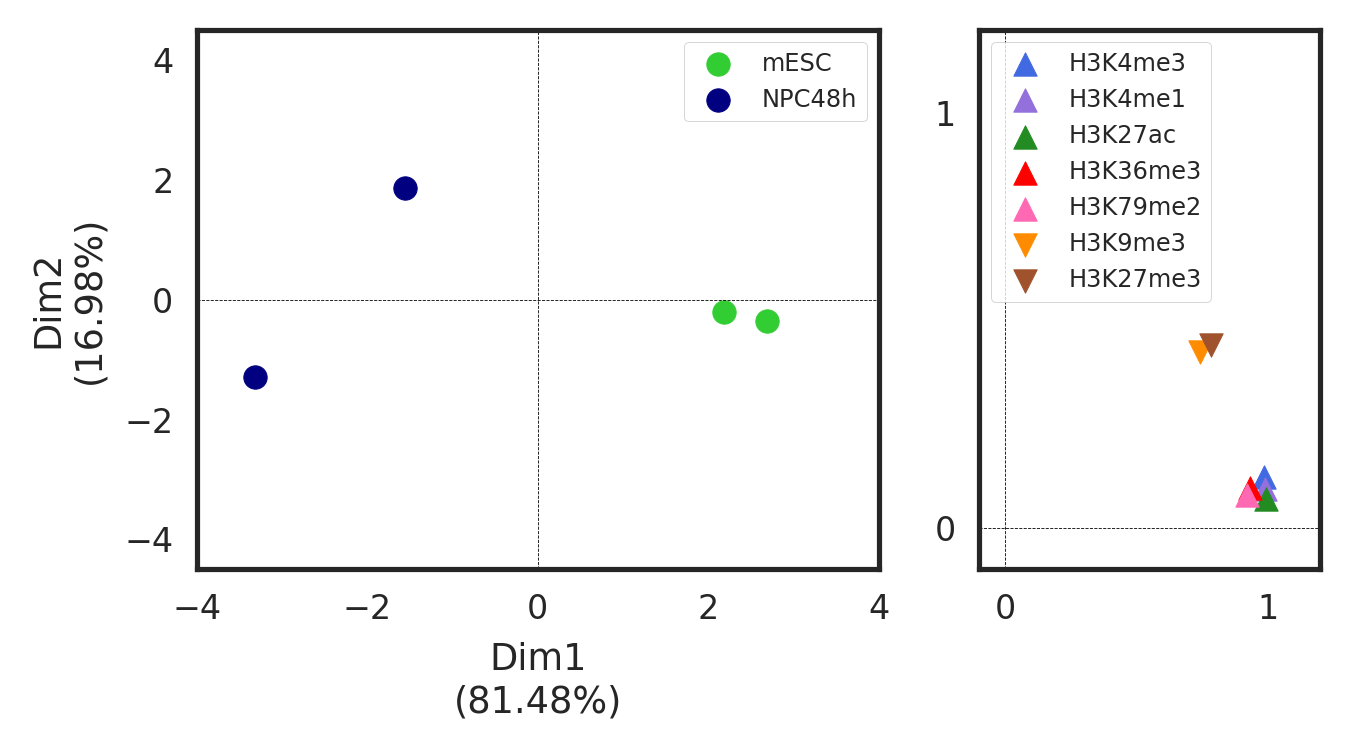

In [5]:
### PLOT RESULTS ###

fig,ax = plt.subplots(1,2, dpi=300, figsize=(4.6,2.6), gridspec_kw = {'width_ratios':[2, 1]})

coord_samples = out_info[0]
coord_groups = out_info[1]
expl_var = out_info[2]

ax[0].scatter(coord_samples[0][:2],coord_samples[1][:2], color = ['limegreen'], label="mESC")
ax[0].scatter(coord_samples[0][2:],coord_samples[1][2:], color = ['navy'], label="NPC48h")
ax[0].set_xlabel("Dim1\n({}%)".format(np.round(expl_var[1][0],2)))
ax[0].set_ylabel("Dim2\n({}%)".format(np.round(expl_var[1][1],2)))
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4.5,4.5)
ax[0].axvline(0, linewidth=0.2,linestyle="--",color='k')
ax[0].axhline(0, linewidth=0.2,linestyle="--",color='k')
ax[0].legend(fontsize='xx-small',frameon=True)

mark=["H3K4me3","H3K4me1","H3K27ac","H3K36me3", "H3K79me2","H3K9me3","H3K27me3"]
cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink'}
shape={"H3K4me3":'^',
      "H3K4me1":'^',
      "H3K27ac":'^',
      "H3K36me3":'^',
      "H3K27me3":'v',
      "H3K9me3":'v',
      "H3K79me2":'^'}

for mark_idx in range(len(mark)):
    ax[1].scatter(coord_groups[0][mark_idx],coord_groups[1][mark_idx], label=mark[mark_idx], color=cols[mark[mark_idx]], marker = shape[mark[mark_idx]])
ax[1].legend(fontsize='xx-small',frameon=True, loc=2)
ax[1].set_xlim(-0.1,1.2)
ax[1].set_ylim(-0.1,1.2)
ax[1].axvline(0, linewidth=0.2,linestyle="--",color='k')
ax[1].axhline(0, linewidth=0.2,linestyle="--",color='k')
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])

plt.tight_layout()

# plt.savefig("../FIGURES/MFA_Epigenome.pdf")

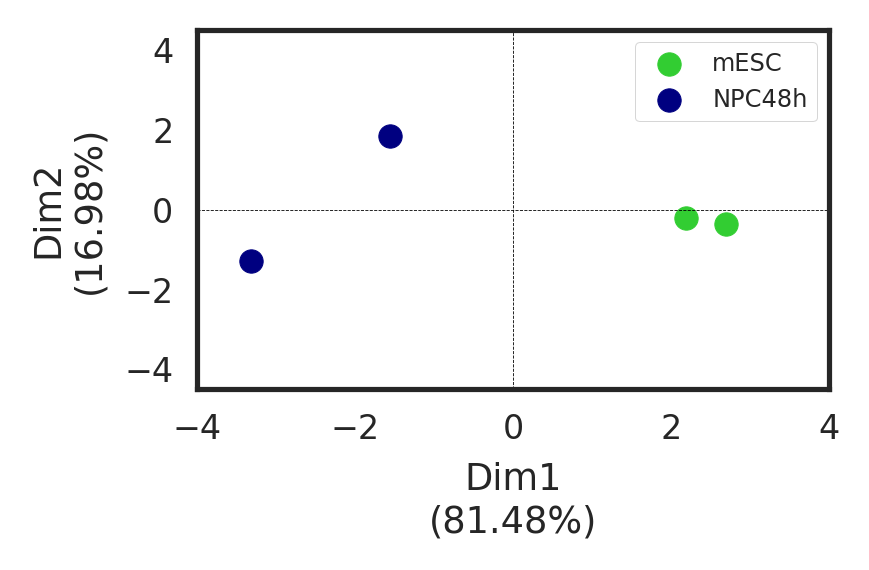

In [6]:
### PLOT DIMENTIONALITY REDUCTION ALONE ###

fig,ax = plt.subplots(dpi=300, figsize=(3,2))

coord_samples = out_info[0]
coord_groups = out_info[1]
expl_var = out_info[2]

ax.scatter(coord_samples[0][:2],coord_samples[1][:2], color = ['limegreen'], label="mESC")
ax.scatter(coord_samples[0][2:],coord_samples[1][2:], color = ['navy'], label="NPC48h")
ax.set_xlabel("Dim1\n({}%)".format(np.round(expl_var[1][0],2)))
ax.set_ylabel("Dim2\n({}%)".format(np.round(expl_var[1][1],2)))
ax.set_xlim(-4,4)
ax.set_ylim(-4.5,4.5)
ax.axvline(0, linewidth=0.2,linestyle="--",color='k')
ax.axhline(0, linewidth=0.2,linestyle="--",color='k')
ax.legend(fontsize='xx-small',frameon=True)

plt.tight_layout()

plt.savefig("../FIGURES/MFA_Epigenome_PCAonly.pdf")

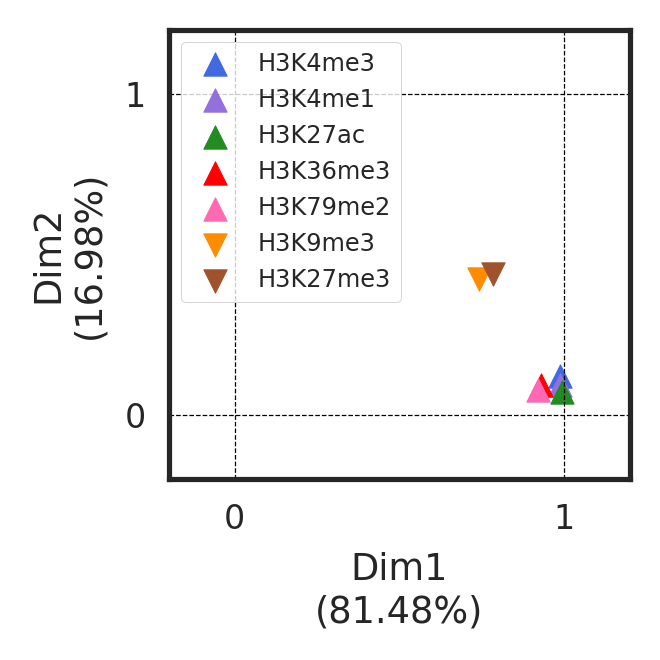

In [7]:
### PLOT FEATURE GROUP CONTRIBUTION TO THE FIRST 2 DIMENTIONS ###

fig,ax = plt.subplots(dpi=300, figsize=(2.3,2.3))


mark=["H3K4me3","H3K4me1","H3K27ac","H3K36me3", "H3K79me2","H3K9me3","H3K27me3"]
cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink'}
shape={"H3K4me3":'^',
      "H3K4me1":'^',
      "H3K27ac":'^',
      "H3K36me3":'^',
      "H3K27me3":'v',
      "H3K9me3":'v',
      "H3K79me2":'^'}

ax.axvline(1,color="k",linestyle="--", linewidth=0.3)
ax.axhline(1,color="k",linestyle="--",linewidth=0.3)
for mark_idx in range(len(mark)):
    ax.scatter(coord_groups[0][mark_idx],coord_groups[1][mark_idx], label=mark[mark_idx], color=cols[mark[mark_idx]], marker = shape[mark[mark_idx]])
ax.legend(fontsize='xx-small',frameon=True, loc=2)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)
ax.axvline(0, linewidth=0.3,linestyle="--",color='k')
ax.axhline(0, linewidth=0.3,linestyle="--",color='k')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xlabel("Dim1\n({}%)".format(np.round(expl_var[1][0],2)))
ax.set_ylabel("Dim2\n({}%)".format(np.round(expl_var[1][1],2)))

plt.tight_layout()
plt.savefig("../FIGURES/MFA_Epigenome_FactorsOnly.pdf")

# Multiple linear regression of expression changes on epigenetic changes:
### Feature selection and multiple linear models evaluation

- Select protein coding genes;
- Define regions where to quantify epigenetic features:
    - H3K4me3 H3K4me1 H3K27ac : TSS +- 1000 (narrow TSS);
    - H3K27me3 H3K79me2 H3K9me3 : TSS -1000 +3000 (extended TSS);
    - H3K36me3 : TES -3000 +500 (TTS)
- Perform NPC48h vs mESC differential analysis for each histone mark on predefined genomic regions;
- Perform a regularized multiple linear regression (lasso) of expression changes on histone modification changes to select best predictive epigenetic features;
- Evaluate overfitting by comparing BIC of 5 competing models;
- Identify genes whose log2 fold-change prediction is affected by inclusion of H3K27ac:H3K79me2 interaction

In [547]:
%%bash

### EXTRACT PROTEIN CODING GENES FROM GTF ###

extract_from_gtf.py -f genes -w gene -prot_cod -o ../INTERMEDIATE_FILES/ \
/home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf


Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=500, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=1000, FEATURE=['genes'], PROTEIN_CODING=True, from_what='gene', gtf_file='/home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf', out_dir='../INTERMEDIATE_FILES/', verbose=False)


In [548]:
%%bash 

### DEFINE TARGET REGIONS FOR QUANTIFICATION ###

#H3K4me3 H3K4me1 H3K27ac
extract_from_bed.py -f TSS -b_tss 1000 -a_tss 1000 -l ../INTERMEDIATE_FILES/genes.bed
mv TSS.bed ../INTERMEDIATE_FILES/narrow_TSS.bed

#H3K27me3 H3K79me2 H3K9me3
extract_from_bed.py -f TSS -b_tss 1000 -a_tss 3000 -l ../INTERMEDIATE_FILES/genes.bed
mv TSS.bed ../INTERMEDIATE_FILES/extended_TSS.bed

#H3K36me3 
extract_from_bed.py -f TES -b_tes 3000 -a_tes 500 -l ../INTERMEDIATE_FILES/genes.bed
mv TES.bed ../INTERMEDIATE_FILES/TES.bed



Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=1000, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=1000, FEATURE=['TSS'], bed_file='../INTERMEDIATE_FILES/genes.bed', limit=True, out_dir='./', verbose=False)
Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=3000, BEFORE_GENE=0, BEFORE_TES=500, BEFORE_TSS=1000, FEATURE=['TSS'], bed_file='../INTERMEDIATE_FILES/genes.bed', limit=True, out_dir='./', verbose=False)
Namespace(AFTER_GENE=0, AFTER_TES=500, AFTER_TSS=500, BEFORE_GENE=0, BEFORE_TES=3000, BEFORE_TSS=1000, FEATURE=['TES'], bed_file='../INTERMEDIATE_FILES/genes.bed', limit=True, out_dir='./', verbose=False)


In [549]:
### FORMAT REGIONS ###

narrow_tss = pd.read_csv("../INTERMEDIATE_FILES/narrow_TSS.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])
narrow_tss = narrow_tss.drop_duplicates(subset=["chr","start","end"])
narrow_tss = narrow_tss.loc[(narrow_tss.chr != "MT")]
narrow_tss.index = narrow_tss.geneID


tes = pd.read_csv("../INTERMEDIATE_FILES/TES.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])
tes = tes.drop_duplicates(subset=["chr","start","end"])
tes = tes.loc[(tes.chr != "MT")]
tes.index=tes.geneID


extended_tss = pd.read_csv("../INTERMEDIATE_FILES/extended_TSS.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])
extended_tss = extended_tss.drop_duplicates(subset=["chr","start","end"])
extended_tss = extended_tss.loc[(extended_tss.chr != "MT")]
extended_tss.index = extended_tss.geneID


common_idx = set(extended_tss.index).intersection(set(narrow_tss.index))
print(len(common_idx))
common_idx = common_idx.intersection(set(tes.geneID.values))
print(len(common_idx))


narrow_tss = narrow_tss.loc[common_idx].dropna()
extended_tss = extended_tss.loc[common_idx]
tes = tes.loc[common_idx]

tes.to_csv("../INTERMEDIATE_FILES/TES_dedup.bed",sep="\t",header=False,index=False)
narrow_tss.to_csv("../INTERMEDIATE_FILES/narrow_TSS_dedup.bed",sep="\t",header=False,index=False)
extended_tss.to_csv("../INTERMEDIATE_FILES/extended_TSS_dedup.bed",sep="\t",header=False,index=False)

21948
21915
21951
21948
21898


In [537]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K4me3 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K4me3_NPCvsESC.txt ../INTERMEDIATE_FILES/narrow_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K4me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam
mark: H3K4me3
outdir: ../INTERMEDIATE_FILES/DIFF_H3K4me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null d

Number of bins found: 21884
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [538]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K4me1 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K4me1_NPCvsESC.txt ../INTERMEDIATE_FILES/narrow_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K4me1

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam
mark: H3K4me1
outdir: ../INTERMEDIATE_FILES/DIFF_H3K4me1
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null d

Number of bins found: 21884
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [539]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K27ac #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K27ac_NPCvsESC.txt ../INTERMEDIATE_FILES/narrow_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K27ac

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam
mark: H3K27ac
outdir: ../INTERMEDIATE_FILES/DIFF_H3K27ac
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null d

Number of bins found: 21884
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [542]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K27me3 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K27me3_NPCvsESC.txt ../INTERMEDIATE_FILES/extended_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K27me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam
mark: H3K27me3
outdir: ../INTERMEDIATE_FILES/DIFF_H3K27me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"


Number of bins found: 21885
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [552]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K36me3 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K36me3_NPCvsESC.txt ../INTERMEDIATE_FILES/TES_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K36me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam
mark: H3K36me3
outdir: ../INTERMEDIATE_FILES/DIFF_H3K36me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"


Number of bins found: 21884
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [543]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K9me3 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K9me3_NPCvsESC.txt ../INTERMEDIATE_FILES/extended_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K9me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam
mark: H3K9me3
outdir: ../INTERMEDIATE_FILES/DIFF_H3K9me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null d

Number of bins found: 21885
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

In [544]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K79me2 #

./pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K79me2_NPCvsESC.txt ../INTERMEDIATE_FILES/extended_TSS_dedup.bed ../INTERMEDIATE_FILES/DIFF_H3K79me2

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam
mark: H3K79me2
outdir: ../INTERMEDIATE_FILES/DIFF_H3K79me2
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"


Number of bins found: 21885
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsp

## FEATURE SELECTION

In [8]:
### LOAD DATA ###

narrow_tss = pd.read_csv("../INTERMEDIATE_FILES/narrow_TSS_dedup.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])
tes = pd.read_csv("../INTERMEDIATE_FILES/TES_dedup.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])
extended_tss = pd.read_csv("../INTERMEDIATE_FILES/extended_TSS_dedup.bed",sep="\t", header=None, names=["chr","start","end",'geneID',"sc","strand","symbol","len"])


narrow_tss.index = ["{}_{}_{}".format(narrow_tss.chr[i],narrow_tss.start[i],narrow_tss.end[i]) for i in narrow_tss.index]
narrow_tss = narrow_tss["geneID"].to_dict()

extended_tss.index = ["{}_{}_{}".format(extended_tss.chr[i],extended_tss.start[i],extended_tss.end[i]) for i in extended_tss.index]
extended_tss = extended_tss["geneID"].to_dict()

tes.index = ["{}_{}_{}".format(tes.chr[i],tes.start[i],tes.end[i]) for i in tes.index]
tes = tes["geneID"].to_dict()

print(len(extended_tss),len(tes), len(narrow_tss))


21898 21898 21898


In [9]:
### CREATE REFERENCE DATAFRAME ###

h3k4me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K4me3/res.tsv",sep="\t",index_col=0)
h3k4me3.columns = ["baseMean_H3K4me3","log2FoldChange_H3K4me3","lfcSE","stat_","pvalue","padj_H3K4me3"]
h3k4me3.index = [narrow_tss[i] for i in h3k4me3.index]
h3k4me3 = h3k4me3[["log2FoldChange_H3K4me3"]]
h3k4me3

h3k4me1 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K4me1/res.tsv",sep="\t",index_col=0)
h3k4me1.columns = ["baseMean_H3K4me1","log2FoldChange_H3K4me1","lfcSE","stat_","pvalue","padj_H3K4me1"]
h3k4me1.index = [narrow_tss[i] for i in h3k4me1.index]
h3k4me1 = h3k4me1[["log2FoldChange_H3K4me1"]]
h3k4me1

m1 = h3k4me3.merge(h3k4me1, how="left", right_index=True, left_index=True)
m1

h3k27ac = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K27ac/res.tsv",sep="\t",index_col=0)
h3k27ac.columns = ["baseMean_H3K27ac","log2FoldChange_H3K27ac","lfcSE","stat_","pvalue","padj_H3K27ac"]
h3k27ac.index = [narrow_tss[i] for i in h3k27ac.index]
h3k27ac = h3k27ac[["log2FoldChange_H3K27ac"]]
h3k27ac

m2 = m1.merge(h3k27ac, how="left", right_index=True, left_index=True)
m2

h3k27me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K27me3/res.tsv",sep="\t",index_col=0)
h3k27me3.columns = ["baseMean_H3K27me3","log2FoldChange_H3K27me3","lfcSE","stat_","pvalue","padj_H3K27me3"]
h3k27me3.index = [extended_tss[i] for i in h3k27me3.index]
h3k27me3 = h3k27me3[["log2FoldChange_H3K27me3"]]
h3k27me3

m3 = m2.merge(h3k27me3, how="left", right_index=True, left_index=True)
m3

h3k36me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K36me3/res.tsv",sep="\t",index_col=0)
h3k36me3.columns = ["baseMean_H3K36me3","log2FoldChange_H3K36me3","lfcSE","stat_","pvalue","padj_H3K36me3"]
h3k36me3.index = [tes[i] for i in h3k36me3.index]
h3k36me3 = h3k36me3[["log2FoldChange_H3K36me3"]]


m4 = m3.merge(h3k36me3, how="left", right_index=True, left_index=True)
m4

h3k9me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K9me3/res.tsv",sep="\t",index_col=0)
h3k9me3.columns = ["baseMean_H3K9me3","log2FoldChange_H3K9me3","lfcSE","stat_","pvalue","padj_H3K9me3"]
h3k9me3.index = [extended_tss[i] for i in h3k9me3.index]
h3k9me3 = h3k9me3[["log2FoldChange_H3K9me3"]]
h3k9me3

m5 = m4.merge(h3k9me3, how="left", right_index=True, left_index=True)

h3k79me2 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K79me2/res.tsv",sep="\t",index_col=0)
h3k79me2.columns = ["baseMean_H3K79me2","log2FoldChange_H3K79me2","lfcSE","stat_","pvalue","padj_H3K79me2"]
h3k79me2.index = [extended_tss[i] for i in h3k79me2.index]
h3k79me2 = h3k79me2[["log2FoldChange_H3K79me2"]]
h3k79me2

m6 = m5.merge(h3k79me2, how="left", right_index=True, left_index=True)
m6["abs_mean_LFC"] = np.fabs(m6).mean(axis=1)
m6["mean_LFC"] = m6.mean(axis=1)
m6

de_nve = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv",sep="\t")
mm = m6.merge(de_nve, how="left", right_index=True, left_index=True)
mm = mm.replace([np.inf,-np.inf],np.nan)
mm = mm.dropna()
mm

,log2FoldChange_H3K4me3,log2FoldChange_H3K4me1,log2FoldChange_H3K27ac,log2FoldChange_H3K27me3,log2FoldChange_H3K36me3,log2FoldChange_H3K9me3,log2FoldChange_H3K79me2,abs_mean_LFC,mean_LFC,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
ENSMUSG00000025764.14,-3.970031,-2.259910,-3.728186,-0.684402,-1.346510,-0.628482,-2.623152,2.177239,-1.632929,11719.905994,-1.659413,0.365775,-1.802784,7.142221e-02,2.046470e-01,Jade1
ENSMUSG00000031285.14,4.631562,1.000312,5.863579,1.160069,3.142119,0.969930,3.593799,2.908767,2.908767,75535.737954,15.467268,0.541438,26.720094,2.749871e-157,1.746237e-153,Dcx
ENSMUSG00000024406.16,-4.082543,-1.818417,-3.839520,-0.254591,-2.935529,-0.919097,-2.951873,2.400224,-1.800168,17119.021345,-3.046090,0.691449,-2.959135,3.085037e-03,1.282747e-02,Pou5f1
ENSMUSG00000023902.18,-3.474238,-2.225546,-5.395381,-0.724773,-4.874793,-1.472311,-2.558561,2.960800,-2.220600,3269.032929,-3.360263,0.625129,-3.775643,1.595953e-04,8.564768e-04,Zscan10
ENSMUSG00000087166.9,-3.621174,-1.328177,-4.327448,0.580844,-3.545348,-0.904751,-2.789912,2.442522,-1.686681,9370.114104,-2.844950,0.651710,-2.830936,4.641202e-03,1.862420e-02,L1td1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000032013.6,-0.499915,-0.404292,0.429180,-0.403270,-0.631643,-0.032984,-0.966234,0.481074,-0.253510,50.408940,-3.882720,0.738526,-3.903341,9.487399e-05,5.274445e-04,Trim29
ENSMUSG00000043336.14,0.325784,1.960139,1.451904,0.101117,0.862735,0.721257,-0.018871,0.777401,0.772683,510.790592,1.978008,0.361073,2.708612,6.756535e-03,2.604290e-02,Filip1l
ENSMUSG00000031209.14,1.760704,-0.642314,0.231968,-0.235239,0.755196,0.218459,-0.111782,0.565095,0.317761,407.715274,-0.559460,0.535978,0.000000,1.000000e+00,1.000000e+00,Heph
ENSMUSG00000031385.14,0.176091,-1.030488,0.481360,-0.999205,-0.483106,-1.681203,0.309850,0.737329,-0.311171,15.096921,-2.450786,0.667388,-2.173826,2.971819e-02,9.622660e-02,Plxnb3


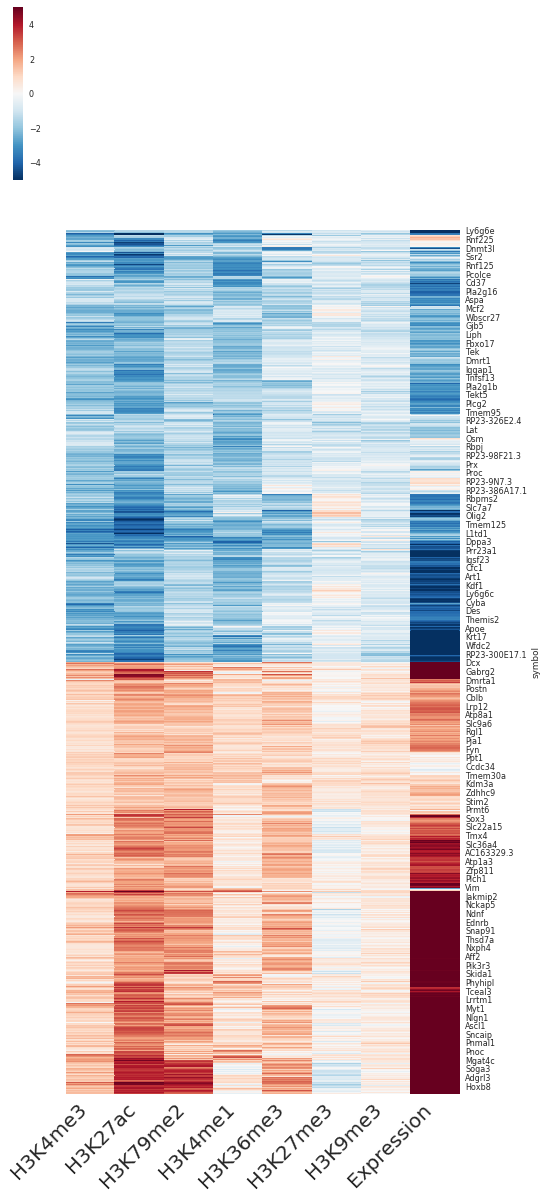

In [10]:
### VISUALIZE ASSOCIATION BETWEEN EPIGENETIC AND TRANSCRIPTIONAL CHANGES ###

n_genes = 1000
mm_ = mm.sort_values(by="abs_mean_LFC",ascending=False)
mm_up = mm.loc[mm.mean_LFC > 0].sort_values(by="mean_LFC", ascending=False)
mm_up = mm_up.loc[mm_up.index[:500]]
mm_down = mm.loc[mm.mean_LFC < 0].sort_values(by="mean_LFC", ascending=True)
mm_down = mm_down.loc[mm_down.index[:500]]
mm_ = pd.concat([mm_up, mm_down])

m_plot = mm_[["log2FoldChange_H3K4me3","log2FoldChange_H3K27ac","log2FoldChange_H3K79me2","log2FoldChange_H3K4me1","log2FoldChange_H3K36me3","log2FoldChange_H3K27me3","log2FoldChange_H3K9me3","log2FoldChange","symbol"]].loc[mm_.index[:n_genes]].dropna()

m_plot.index = m_plot.symbol
m_plot.drop("symbol",axis=1,inplace=True)
m_plot.columns = ["H3K4me3","H3K27ac","H3K79me2","H3K4me1","H3K36me3","H3K27me3","H3K9me3","Expression"]

g = sns.clustermap(m_plot, cmap="RdBu_r", center=0, col_cluster=False, vmin=-5,vmax=5, figsize=(8,20))
g.ax_row_dendrogram.set_visible(False)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45,ha="right")

g.savefig("../FIGURES/Clustermap_topVar_loci-genes_Epigenome.png", dpi=400)


In [11]:
#### PERFORM FEATURE SELECTION USING LASSO ####

X = mm[list(mm)[:7]]
X["inter_H3K79me2:H3K27ac"] = mm.log2FoldChange_H3K27ac * mm.log2FoldChange_H3K79me2
X["inter_H3K79me2:H3K36me3"] = mm.log2FoldChange_H3K36me3 * mm.log2FoldChange_H3K79me2
X["inter_H3K27ac:H3K36me3"] = mm.log2FoldChange_H3K36me3 * mm.log2FoldChange_H3K27ac
y = mm["log2FoldChange"]

reg = LassoCV(cv = 10, normalize=False, positive=True)
reg.fit(X, y)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
imp_coef = coef.sort_values(ascending=False)
imp_coef

/package/anaconda3/bin/ipython:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import re
/package/anaconda3/bin/ipython:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/package/anaconda3/bin/ipython:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Best score using built-in LassoCV: 0.434559


log2FoldChange_H3K27ac     0.973985
log2FoldChange_H3K36me3    0.730561
log2FoldChange_H3K79me2    0.253028
inter_H3K79me2:H3K27ac     0.217939
inter_H3K27ac:H3K36me3     0.000000
inter_H3K79me2:H3K36me3    0.000000
log2FoldChange_H3K9me3     0.000000
log2FoldChange_H3K27me3    0.000000
log2FoldChange_H3K4me1     0.000000
log2FoldChange_H3K4me3     0.000000
dtype: float64

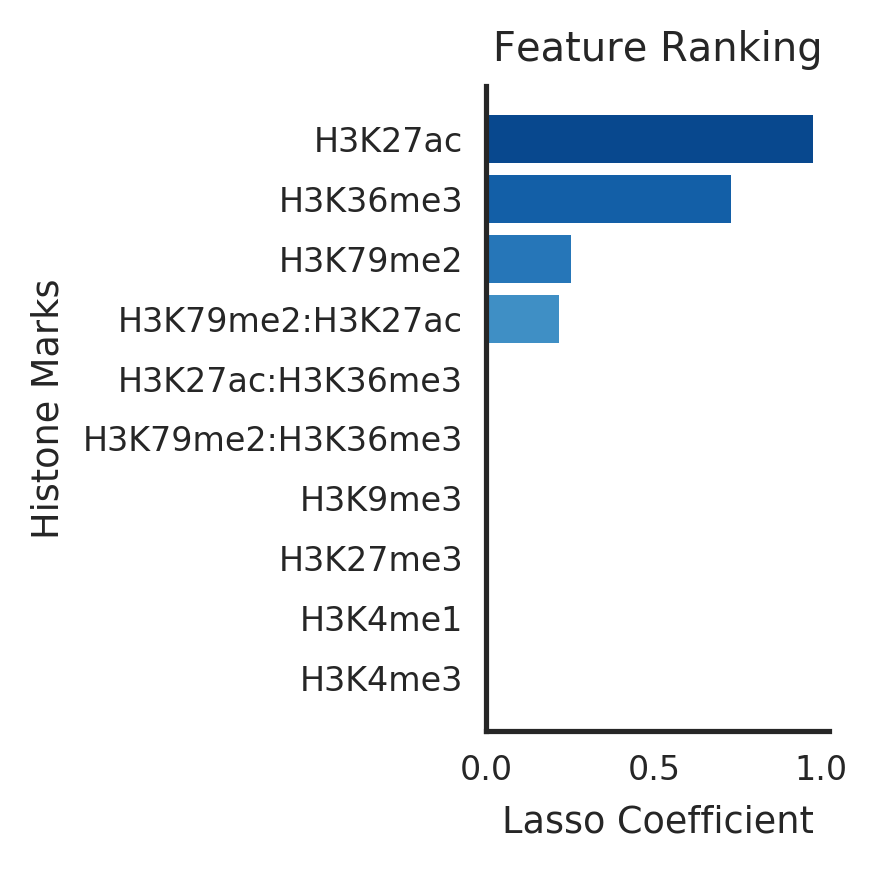

In [12]:
### PLOT RESULTS ###

fig,ax = plt.subplots(dpi=300, figsize=(3,3))
ax.barh(range(imp_coef.shape[0]),imp_coef.values[::-1], color=sns.color_palette("Blues_r",imp_coef.shape[0])[::-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(range(imp_coef.shape[0]))
ax.set_yticklabels([i.split("_")[-1] for i in imp_coef.index][::-1])
ax.set_title("Feature Ranking")
ax.set_xlabel("Lasso Coefficient")
ax.set_ylabel("Histone Marks")
plt.tight_layout()

plt.savefig("../FIGURES/Feature_ranking_CVlambda_positiveOnly.pdf")

In [13]:
#### EVALUATE MODEL PERFORMANCE ####


### H3K27ac H3K36me3 H3K79me2
X_0 =  mm[["log2FoldChange_H3K27ac","log2FoldChange_H3K36me3","log2FoldChange_H3K79me2"]]

### H3K27ac H3K36me3 H3K36me3 H3K79me2:H3K27ac
X_1 =  mm[["log2FoldChange_H3K27ac","log2FoldChange_H3K36me3","log2FoldChange_H3K79me2"]].copy()
X_1["inter_H3K27ac:H3K79me2"] = mm.log2FoldChange_H3K27ac * mm.log2FoldChange_H3K79me2

### all marks with no interaction 
X_2 = mm[list(mm)[:7]]

### H3K27ac H3K36me3 H3K79me2:H3K27ac
X_3 =  mm[["log2FoldChange_H3K27ac","log2FoldChange_H3K36me3"]].copy()
X_3["inter_H3K27ac:H3K79me2"] = mm.log2FoldChange_H3K27ac * mm.log2FoldChange_H3K79me2

### H3K36me3 H3K79me2
X_4 =  mm[["log2FoldChange_H3K36me3","log2FoldChange_H3K79me2"]].copy()
X_4["inter_H3K27ac:H3K79me2"] = mm.log2FoldChange_H3K27ac * mm.log2FoldChange_H3K79me2

### H3K27ac H3K36me3
X_5 =  mm[["log2FoldChange_H3K27ac","log2FoldChange_H3K36me3"]]


### RESPONSE
y = mm.log2FoldChange


/home/ferrari/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log2FoldChange   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3117.
Date:                Fri, 31 Jan 2020   Prob (F-statistic):               0.00
Time:                        22:24:48   Log-Likelihood:                -34093.
No. Observations:               16161   AIC:                         6.819e+04
Df Residuals:                   16157   BIC:                         6.823e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
log2FoldChange_H3K27ac      0.9020      0.021     42.436      0.000       0.860       0.944
log2FoldChange_H3K36me3     0.7613      0.030     25.647      0.000       0.703       0.819
log2FoldChange_H3K79me2     0.3545      0.031     11.532      0.000       0.294       0.415
inter_H3K27ac:H3K79me2      0.2969      0.009     31.323      0.000       0.278       0.315
==============================================================================
Omnibus:                     3311.213   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11782.258
Skew:                           1.008   Prob(JB):                         0.00
Kurtosis:                       6.665   Cond. No.                         3.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

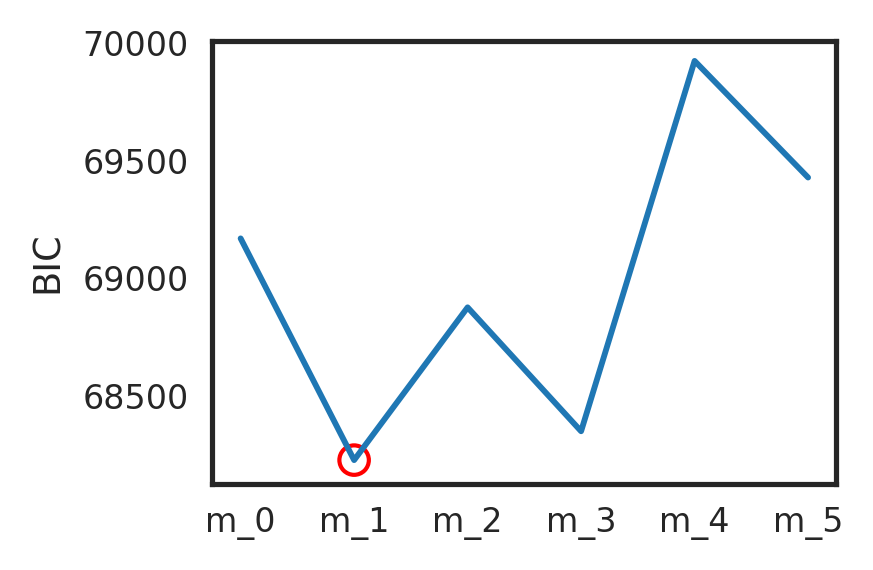

In [14]:
### COMPARE BAYESIAN INFORMATION CRITERIA BETWEEN COMPETING LINEAR MODELS ###

bics = []
r = []
r_adj = []

X_00 = sm.add_constant(X_0)
mo_00 = sm.OLS(y, X_0).fit()
bics.append(mo_00.bic)
r_adj.append(mo_00.rsquared_adj)
r.append(mo_00.rsquared)

X_11 = sm.add_constant(X_1)
mo_11 = sm.OLS(y, X_1).fit()
bics.append(mo_11.bic)
r_adj.append(mo_11.rsquared_adj)
r.append(mo_11.rsquared)

X_22 = sm.add_constant(X_2)
mo_22 = sm.OLS(y, X_2).fit()
bics.append(mo_22.bic)
r_adj.append(mo_22.rsquared_adj)
r.append(mo_22.rsquared)

X_33 = sm.add_constant(X_3)
mo_33 = sm.OLS(y, X_3).fit()
bics.append(mo_33.bic)
r_adj.append(mo_33.rsquared_adj)
r.append(mo_33.rsquared)

X_44 = sm.add_constant(X_4)
mo_44 = sm.OLS(y, X_4).fit()
bics.append(mo_44.bic)
r_adj.append(mo_44.rsquared_adj)
r.append(mo_44.rsquared)

X_55 = sm.add_constant(X_5)
mo_55 = sm.OLS(y, X_5).fit()
bics.append(mo_55.bic)
r_adj.append(mo_55.rsquared_adj)
r.append(mo_55.rsquared)


### PLOT RESULTS
plt.figure(dpi=300,figsize=(3,2))
plt.plot(bics)
plt.xticks(range(6),["m_0","m_1","m_2","m_3","m_4","m_5"])
bics_ = np.array(bics)
minn = np.argmin(bics_)
plt.scatter([minn],bics[minn], s=50,edgecolor='r',facecolor='None', linewidth=1)
plt.ylabel("BIC")
plt.tight_layout()

plt.savefig("../FIGURES/BIC_models.pdf")
mo_11.summary()

16161


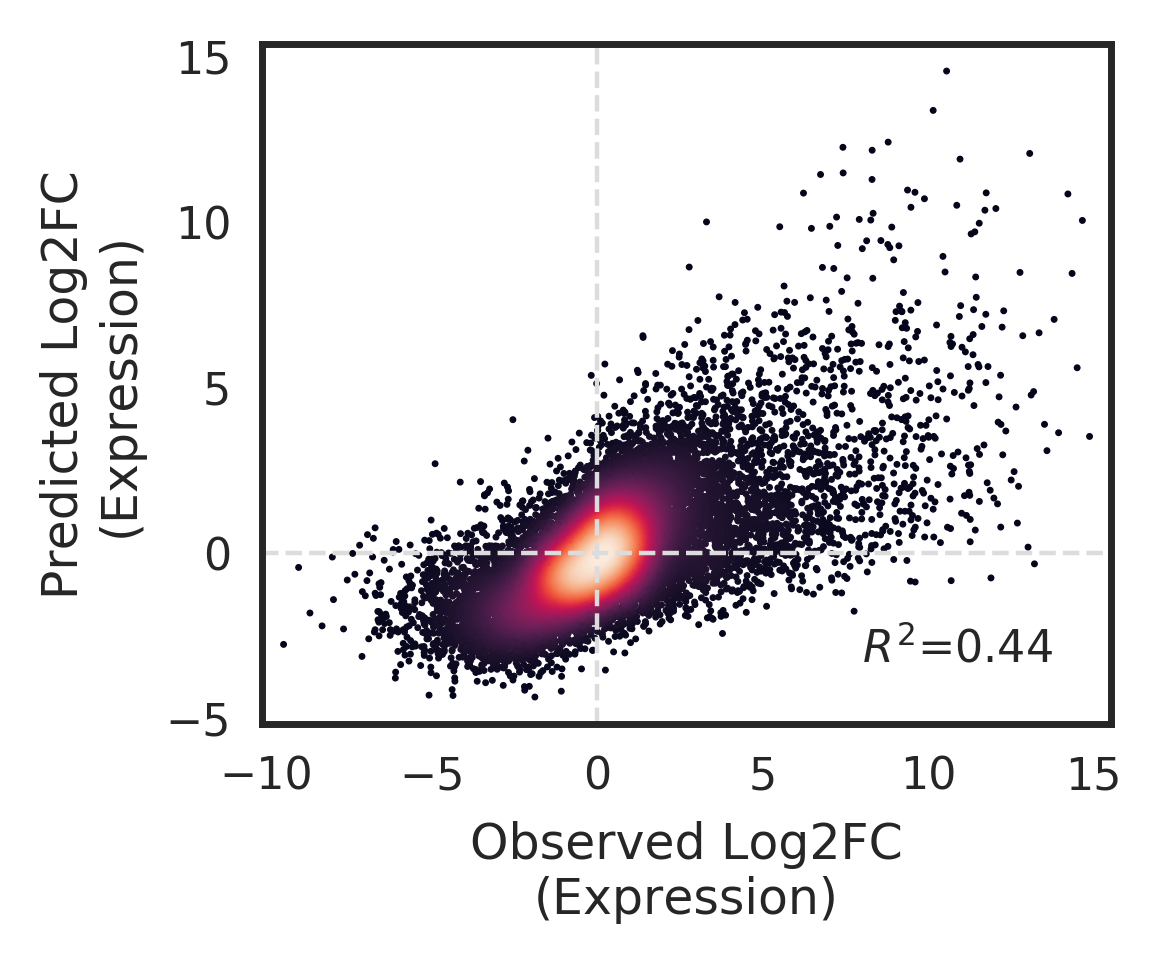

In [16]:
### VISUALIZE MODEL FIT (OBSERVED VS PREDICTED EXPRESSION LOG2 FOLD-CHANGE)###
#
fig,ax = plt.subplots(dpi=400, figsize=(3,2.5))
plt.axis('equal')
y_predict = mo_11.predict(X_1)
y_in = y.values.reshape(-1,1)
r_squared = round(mo_11.rsquared,2)
correlation = round(np.corrcoef(y.values,y_predict)[1][0],2)
rel.density_scatter(y.values,y_predict,ax=ax)
ax.set_xlabel("Observed Log2FC\n(Expression)")
ax.set_ylabel("Predicted Log2FC\n(Expression)")

ax.annotate(r'$R^2$'+"={}".format(r_squared),(8,-3.3),size=8)

ax.axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax.axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")
plt.tight_layout()
print(len(y_in))

plt.savefig("../FIGURES/ObservedVsPredicted_ExpL2FC.png")

In [17]:
X_base = mm[list(mm)[:7]]
y = mm["log2FoldChange"]

reg_base = LassoCV(cv = 10, normalize=False, positive=True)

reg_base.fit(X_base, y)

print("Best score using built-in LassoCV: %f" % reg_base.score(X_base,y))
coef_base = pd.Series(reg_base.coef_, index = X_base.columns)
imp_coef_base = coef_base.sort_values(ascending=False)
imp_coef_base

Best score using built-in LassoCV: 0.417331


log2FoldChange_H3K27ac     0.943480
log2FoldChange_H3K36me3    0.743015
log2FoldChange_H3K79me2    0.319260
log2FoldChange_H3K9me3     0.000000
log2FoldChange_H3K27me3    0.000000
log2FoldChange_H3K4me1     0.000000
log2FoldChange_H3K4me3     0.000000
dtype: float64

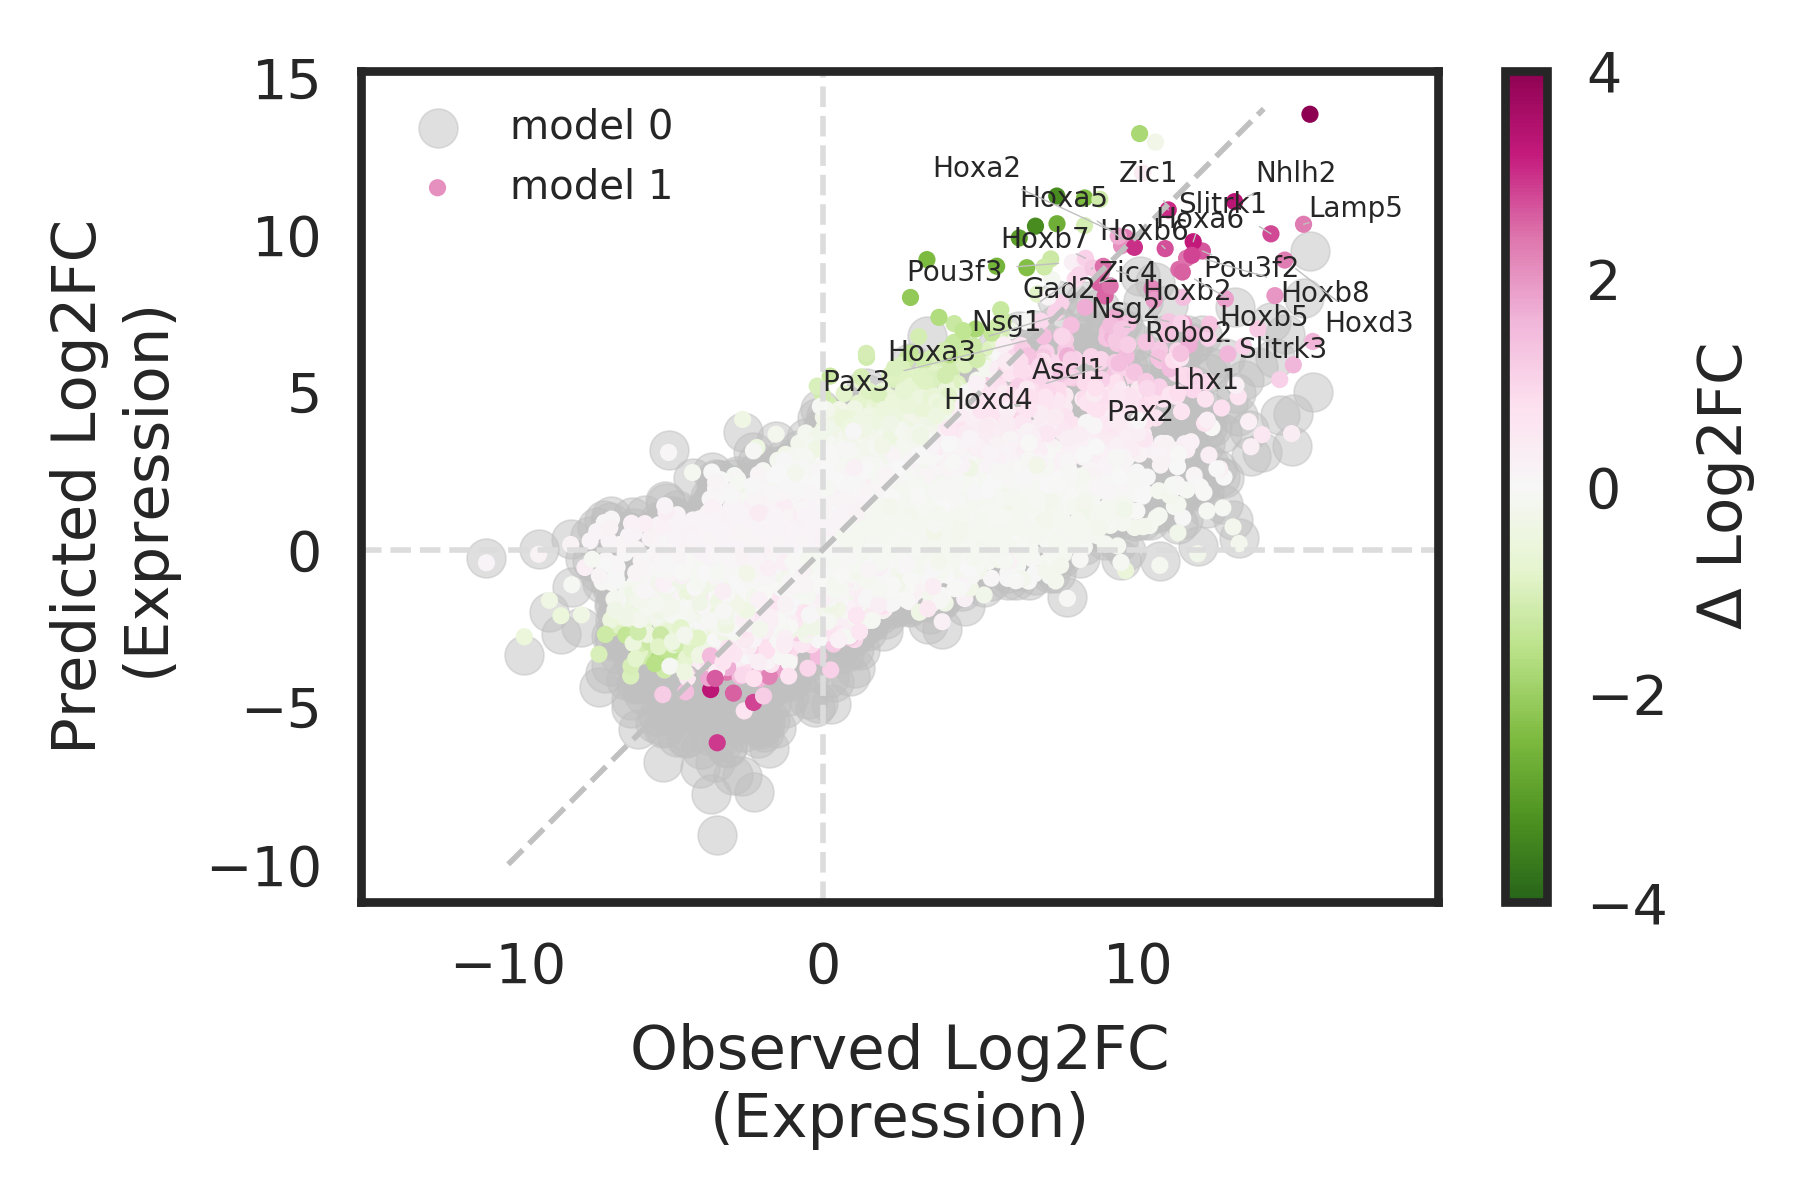

In [18]:
fig,ax=plt.subplots(dpi=500,figsize=(3.7,2.5))

y_predict = pd.Series(reg.predict(X), index = X.index)
y_predict_base = pd.Series(reg_base.predict(X_base), index = X_base.index)
y_in_df = pd.Series(mm["log2FoldChange"], index = mm["log2FoldChange"].index)
plt.axis('equal')
plo = pd.concat([y_predict,y_predict_base, y_in_df], axis=1 )
#plo = pd.concat([plo,y_in_df], axis=1 )
plo.columns = ['predict',"predict_base","y_in"]

plo['diff'] = plo['predict'] - plo['predict_base']
plo["delta_m_base"] =  np.fabs(plo["predict_base"] - plo["y_in"])
plo["delta_m"] = np.fabs(plo["predict"] - plo["y_in"]) 
plo['delta_fin'] = plo["delta_m_base"] - plo["delta_m"]
plo.sort_values(by="diff", ascending=False).head(n=20)

tr = pd.read_csv("../INTERMEDIATE_FILES/genes.bed",sep="\t",header=None, index_col=3)
tr = tr[6].to_dict()
plo.index = [tr[i] if i in tr else i for i in plo.index]


minima = -4 
maxima = 4 
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.PiYG_r)
mapper.set_array(plo.delta_fin)
rgba_list=[]
for v in plo["delta_fin"]:
    rgba_list.append(mapper.to_rgba(v))

ax.scatter(y.values,y_predict_base, color="silver",alpha=0.5, label = "model 0")

ax.scatter(y.values,y_predict,s=5,c=rgba_list, label = "model 1")

ax.set_xlabel("Observed Log2FC\n(Expression)")
ax.set_ylabel("Predicted Log2FC\n(Expression)")
ax.axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax.axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")

ax.plot(np.arange(-10,15), np.arange(-10,15), linewidth=0.8, linestyle='--', color='silver')
cbar=plt.colorbar(mapper)

cbar.set_label(r'$\Delta$'+' Log2FC')


idx = ["Ascl1","Gad2","Hoxa2","Hoxa3","Hoxa5","Hoxa6","Hoxb2","Hoxb5","Hoxb6","Hoxb7","Hoxb8","Hoxd3","Hoxd4",
      "Lamp5", "Nhlh2","Pax2","Pax3","Pou3f2","Lhx1","Pou3f3","Robo2","Zic1","Zic4","Slitrk1","Slitrk3","Nsg1","Nsg2"]

texts = [plt.text(plo["y_in"].loc[idx].values[i], plo["predict"].loc[idx].values[i], "{}".format(plo.loc[idx].index[i]), ha='center', va='center',  fontsize=4) for i in range((plo.loc[idx].shape[0]))]
adjust_text(texts,expand_text=(1.1, 1.2), arrowprops=dict(arrowstyle="-", color='silver', lw=0.2))

plt.legend(loc=2, fontsize='xx-small')
plt.tight_layout()

plt.savefig("../FIGURES/Improvements_due_to_interaction_term.png")